Prog binaryzacji:  0.5492087913602941


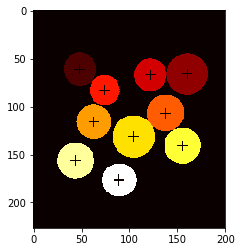

Ilosc obiektow: 10
rozmiar obiektow to: 10980
Pole zajmowane przez obiekty: 24.19%
Obiekt o środku ciezkosci: (61, 48) Współczynnik Fereta: 1.0303030303030303 Współczynnik Bliss'a: 0.9998909684354478
Obiekt o środku ciezkosci: (66, 160) Współczynnik Fereta: 1.0 Współczynnik Bliss'a: 0.9999013018492539
Obiekt o środku ciezkosci: (67, 122) Współczynnik Fereta: 1.0 Współczynnik Bliss'a: 1.0000001082777783
Obiekt o środku ciezkosci: (83, 74) Współczynnik Fereta: 0.967741935483871 Współczynnik Bliss'a: 0.9999052105507434
Obiekt o środku ciezkosci: (107, 137) Współczynnik Fereta: 1.0 Współczynnik Bliss'a: 0.9999560337854517
Obiekt o środku ciezkosci: (107, 138) Współczynnik Fereta: 1.0 Współczynnik Bliss'a: 0.9999566942907209
Obiekt o środku ciezkosci: (116, 63) Współczynnik Fereta: 1.0 Współczynnik Bliss'a: 1.0000272573881877
Obiekt o środku ciezkosci: (131, 104) Współczynnik Fereta: 0.972972972972973 Współczynnik Bliss'a: 0.999832793068262
Obiekt o środku ciezkosci: (141, 155) Współczynnik

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage import filters, morphology
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from scipy.spatial import distance

path = './images/' 

image = io.imread(path +'01.png')
image = rgb2gray(image)
#image = filters.median(image)

th = filters.threshold_otsu(image)
print('Prog binaryzacji: ', th)

binary = image > th
binary = morphology.remove_small_holes(binary)

d = ndi.distance_transform_edt(binary) #oblicza odleglosci od krawedzi
local_max = peak_local_max(d, indices=False, min_distance=15, labels=binary)# szuka punktu najdalej oddalonego od krawedzi

markers = ndi.label(local_max)[0] #ideksy
ilosc_obiektow = ndi.label(local_max)[1] # ilosc obiektow
labels = morphology.watershed(-d, markers, mask=binary)


sr_ciezkosci = []
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i][j] != 0:
            sr_ciezkosci.append((i,j))
            
def drawMarkers(image, coords):
    image = np.copy(image)
    for item in coords:
        y,x = item
        for j in range(y-5, y+6):
            image[j,x] = 0
        for i in range(x-5, x+6):
            image[y,i] = 0
            
    return image

def cog2(points):
    mx = 0
    my = 0
    for (y, x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)

    return [my, mx]

def bliss(points):
    s = len(points)
    my, mx = cog2(points)
    r = 0
    for point in points:
        r = r + distance.euclidean(point, (my, mx))**2
    return s/(math.sqrt(2*math.pi*r))

def feret(points):
    px = [x for (y, x) in points]
    py = [y for (y, x) in points]

    fx = max(px) - min(px)
    fy = max(py) - min(py)    
    if fx != 0:
        return float(fy)/float(fx)
    
lo = drawMarkers(labels, sr_ciezkosci)
plt.imshow(lo,cmap='hot')
plt.show()
    
tab_feret =[]
tab_bliss =[]    
rozmiar_obiektow = 0
for label in np.unique(labels):
    if label == 0: continue
    points = []
    
    mask = np.zeros(binary.shape, dtype="uint8")
    mask[labels == label] = 255
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == 255:
                points.append((i, j))
    
    tab_feret.append(feret(points))
    tab_bliss.append(bliss(points))

    rozmiar_obiektow += len(points)
    
print("Ilosc obiektow: {}".format(ilosc_obiektow))
print("rozmiar obiektow to: {}".format(rozmiar_obiektow))
print("Pole zajmowane przez obiekty: {:.2%}".format((rozmiar_obiektow*100)/(image.shape[0]*image.shape[1])/100)) 
for i in range(ilosc_obiektow):
    print("Obiekt o środku ciezkosci: {} Współczynnik Fereta: {} Współczynnik Bliss'a: {}".format(sr_ciezkosci[i], tab_feret[i], tab_bliss[i]))